# Hypothesis testing with NBA statistics

In phase II of the final project, we will examine four phenomena in basketball:
1. Home court advantage: We'll test the hypothesis that teams have an advantage when playing at home.
2. Weekend vs weekday: We'll test the hypothesis that teams have different scoring patterns on weekdays vs weekends.
3. Michael Jordan effect: We'll test the hypothesis that Michael Jordan improved the Chicago Bulls scores.
4. Rest days (optional): We'll test the hypothesis that having more rest days affects game scores.

The tests will be run with real NBA data. This dataset is provided to you in `nba_data.csv` in the same directory as this notebook. We also provide a utility function in `utils.py`.

**Due date:** May 10, 2024 11:59pm

**Total:** 65 pts

**Submission:** Please submit a zip file containing this .ipynb file and a pdf version of this file

In [232]:
#Import the necessary libraries
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from scipy import stats
import warnings
import utils

warnings.filterwarnings('ignore')
plt.rc('font', size = 14)

## 1. Data

Let's start by exploring and visualizing the data.

**(1a).** [1 pt] Read the data file (`nba_data.csv`) as a pandas dataframe. Store the dataframe object in a variable called `df`. What is the total number of games in the dataset? Display the first 5 rows.

*Hint:* First, use the `read_csv()` function in pandas. Then, to convert the date column into pandas DateTime format, use the `pd.to_datetime()` function with format string `"%A, %B %d, %Y"`

In [233]:
df = pd.read_csv('nba_data.csv')
print(df.head())


df['date'] = pd.to_datetime(df['date'], format="%A, %B %d, %Y")

total_games = df.shape[0]
print("Total number of games:", total_games)


   season                        date  home_pt               home_team  \
0    1950  Saturday, October 29, 1949       93   Tri-Cities Blackhawks   
1    1950   Tuesday, November 1, 1949       87           Chicago Stags   
2    1950   Tuesday, November 1, 1949       71  Indianapolis Olympians   
3    1950   Tuesday, November 1, 1949      108        Rochester Royals   
4    1950   Tuesday, November 1, 1949       72       St. Louis Bombers   

   away_pt              away_team finished_in  winner_pt  margin  
0       85         Denver Nuggets         NaN         93       8  
1       89        New York Knicks          OT         89       2  
2       64         Denver Nuggets  regulation         71       7  
3       75    Sheboygan Red Skins  regulation        108      33  
4       51  Tri-Cities Blackhawks  regulation         72      21  
Total number of games: 60688


**(1b).** [2 pts] Plot the average home and away score per game for each season (score on y-axis, season on x-axis). Start with season 1960 and end with season 2017. Comment on the general trends across all these years. Label the plot axes, add a title, and include a legend.

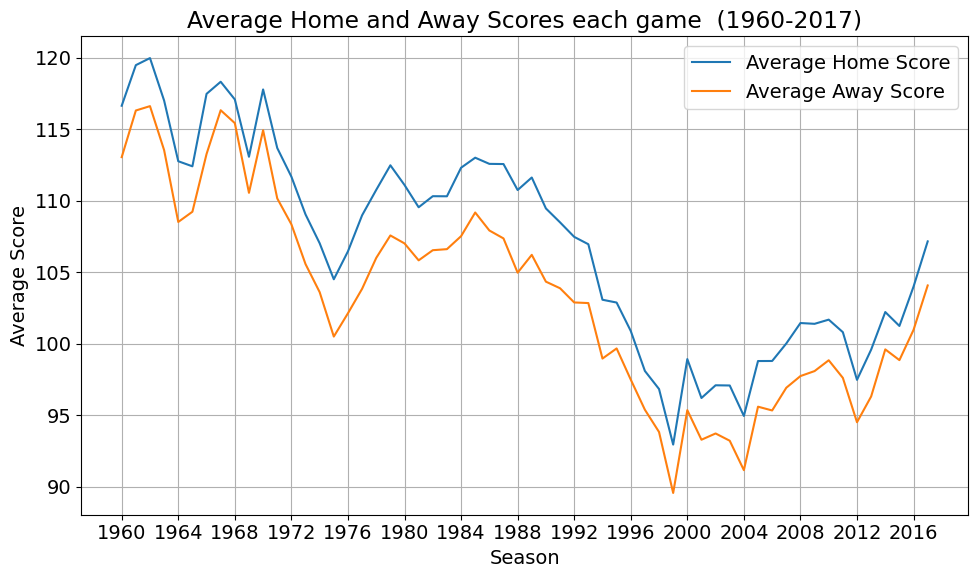

In [240]:
filtered_df = df[(df['season'] >= 1960) & (df['season'] <= 2017)]

average_scores = filtered_df.groupby('season').agg({'home_pt': 'mean', 'away_pt': 'mean'}).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(average_scores['season'], average_scores['home_pt'], label='Average Home Score')
plt.plot(average_scores['season'], average_scores['away_pt'], label='Average Away Score')
plt.xlabel('Season')
plt.ylabel('Average Score')
plt.title('Average Home and Away Scores each game  (1960-2017)')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(1960, 2018, step=4))
plt.tight_layout()
plt.show()


**A:**  Looks like there is some sort of seasonality. The general trend for both home and away seem to be correlate in fluctuation while average home scoring consistently remained greater. Overrall, through the years there is a genera downward trend. However, you could see the decrease (increase in intensity as scoring seemed to be getting more difficult) between the 60s up until 00's, where around the 90's the minimum average seemed to have occurred. From then on, trend seems upward. The max averages remain a thing of the 60s.

**(1c).** [1 pt] Add a column `total_score` to `df`.

To help you check your code works, we added a test case below that should pass with your amended dataframe. Note that the test cases in this project are not exhaustive, so you should still check if your function is correct even if the test cases pass.

In [241]:
df['Total score']= df['home_pt'] + df['away_pt']


In [242]:
assert df.loc[np.logical_and(df['home_team']=='Boston Celtics',
                             df['date'] == pd.to_datetime('2017-05-25'))]['Total score'].values[0] == 237

**(1d).** [2 pts] Write a function called <b>weekend_new_column()</b> to create two new columns: <br><br>

`day_of_week`: this column should be set to an integer between $0$ an $6$, both inclusive. If the game was played on Monday then set `day_of_week = 0`, if it was played on Tuesday then `day_of_week = 1`, ...., and if it was played on Sunday then `day_of_week = 6`.

`weekend`: this column should be set to either 0 or 1. If the game was played over the weekend, i.e. on Saturday or Sunday then it should be = 1, else 0.

Feel free to follow the example here: https://stackoverflow.com/questions/52398383/finding-day-of-the-week-for-a-datetime64.

<b>Make sure to double-check that the column content matches the convention we defined above! (It is easy to make off-by-one mistakes)</b>

Your function should pass the test cases below.

In [243]:
def weekend_new_column(df):
    '''
    Add two columns to the dataframe
    @param df: dataframe containing column 'date', will be modified by function
    @return: None
    '''
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    return df


In [244]:
weekend_new_column(df)
# rewrite test cases to check against date column in case students shuffled the dataframe
assert df.loc[df['date'] == pd.to_datetime('2017-06-07')].day_of_week.values[0] == 2
assert df.loc[df['date'] == pd.to_datetime('2017-06-07')].weekend.values[0]     == 0
assert df.loc[df['date'] == pd.to_datetime('2017-06-04')].day_of_week.values[0] == 6
assert df.loc[df['date'] == pd.to_datetime('2017-06-04')].weekend.values[0]     == 1


## 2. Generalized likelihood ratio test for home advantage as a proportion

We will use the NBA dataset to determine whether "home-court advantage" is statistically significant. Some people believe a team will perform better playing at home because they are more familiar with the environment, less tired from traveling, and more supported by their fans. This article explains what home court advantage is: https://bleacherreport.com/articles/1520496-how-important-is-home-court-advantage-in-the-nba

We will define home advantage as follows for this part: The proportion of wins at home for a team is higher than the proportion of wins away for that team.

Let $A_k$ be an indicator random variable for whether team $k$ is playing a game at home. Let $B_k$ be an indicator random variable for whether team $k$ wins the game. We are testing for the independence of $A_k$ and $B_k$. When testing for independence of two discrete variables, we can construct a contingency table where the rows are the values of one variable and the columns are the values of the other variable. Then we can use the generalized likelihood ratio test. Let $i$ and $j$ index the rows and columns, respectively, of the contingency table. This test examines whether the number of observations $O_{ij}$ in each entry of the contingency table aligns with the expected numbers $E_{ij}$. The statistic is based on likelihood ratios:

\begin{equation}
    G = 2 \sum_{i,j} O_{ij} \ln \left(\frac{O_{ij}}{E_{ij}}\right)
\end{equation}

The G-statistic follows a chi-squared distribution with (number of rows - 1)(number of columns - 1) as the number of degrees of freedom.

**(2a).** [2 pts] For a single team $k$, state your null and alternative hypotheses using the random variables $A_k$ and $B_k$ defined above.

**A:** H_0 : P(B_k =1 | A_k =1) == P(B_k =1 | A_k =0) ; 

H_1: P(B_k =1 | A_k =1) != P(B_k =1 | A_k =0)

**(2b).** [1 pt] We will restrict the data to seasons 2000-2017 for parts 2 and 3. This is because the mean yearly scores prior to season 2000 demonstrate far greater variance than during this most recent period. Ideally, we want to answer questions about home advantage, for example, during a period when the inter-seasonal variability was less extreme. Create a subset of the dataframe called `df_millenial_subset` for seasons in the range $[2000, 2017]$ (both inclusive).

In [246]:
df_millenial_subset  =df[(df['season'] >=2000) & (df['season']  <= 2017)]

**(2c).** [1 pt] To ensure we have sufficient data for each hypothesis test, we will only test the home advantage hypothesis for teams that play in all 18 seasons. Create a list `team_names_in_all_seasons` of teams that play in all 18 seasons. Print the number of teams in your list.

Note that although we will not test the hypotheses for the excluded teams, matches that include those teams may still be used for the hypothesis tests you conduct.

In [247]:
team_season_counts = df_millenial_subset.groupby('home_team')['season'].nunique()
team_names_in_all_seasons = []
for team_name, season_count in team_season_counts.items():
    if season_count == 18:
        team_names_in_all_seasons.append(team_name)
print(len(team_names_in_all_seasons))

25


**(2d).** [2 pts] For each team in the list you created in 2c, create a 2x2 contingency table that contains `home` and `away` as the two rows and `wins` and `losses` as the two columns. The entry in the row `home` and column `wins` is the number of home games that are won by that team. The entry in the row `away` and column `losses` is the number of away games that are lost by that team. The other two entries are defined analogously.

Keep a list called `observed_tables` containing the contingency tables. This list should follow the order in `team_names_in_all_seasons`.

Print the table for the New York Knicks.

Your table for the Boston Celtics should pass the test case given below. The test case is written assuming the contingency tables are saved in pandas data frames since that allows the rows and columns to be titled. Other data structures will also be accepted. If you use a different data structure, feel free to modify the test cases in 2d and 2e, as well as the function specification in 2f.

In [253]:
observed_tables = []

for team in team_names_in_all_seasons:
    team_data= df_millenial_subset
    home_wins = ((team_data['home_team'] == team) & (team_data['away_pt'] < team_data['home_pt'])).sum()
    away_losses =((team_data['away_team'] == team) & (team_data['away_pt'] <team_data['home_pt'])).sum()
    away_wins = ((team_data['away_team'] == team) & (team_data['away_pt'] > team_data['home_pt'])).sum()
    home_losses = ((team_data['home_team']== team) & (team_data['away_pt'] > team_data['home_pt'])).sum()
    
    table = pd.DataFrame({'Wins': [home_wins, away_wins],'Losses': [home_losses, away_losses]}, index=['Home', 'Away'])
    
    observed_tables.append(table)
print("table for New York Knicks:")
print(observed_tables[team_names_in_all_seasons.index('New York Knicks')])


table for New York Knicks:
      Wins  Losses
Home   392     361
Away   252     501


In [254]:
boston_celtics_idx = team_names_in_all_seasons.index('Boston Celtics')
assert np.all(observed_tables[boston_celtics_idx].values == np.array([[506, 308], [359, 450]]))

**(2e).** [2 pts] Create a list of tables `expected_tables` in the same format containing the expected number of samples for each entry under the null hypothesis. The teams should be in the same order as `team_names`.

Print the table for the New York Knicks.

Your table for the Boston Celtics should pass the test case given below.

*Hint:* The marginal probabilities for each row and column may be helpful when computing the expected values.

In [260]:
expected_tables= []

for team in team_names_in_all_seasons:
    team_data  = df_millenial_subset
    
    row_total_home =  ((team_data['home_team'] == team)).sum()
    row_total_away= ((team_data['away_team'] == team)).sum()
    col_total_wins = ((team_data['home_team'] == team) & (team_data['away_pt'] < team_data['home_pt'])).sum() + ((team_data['away_team'] == team) & (team_data['away_pt'] > team_data['home_pt'])).sum()
    col_total_losses = ((team_data['home_team'] == team) & (team_data['away_pt'] > team_data['home_pt'])).sum() + ((team_data['away_team'] == team) & (team_data['away_pt'] < team_data['home_pt'])).sum()
    total_samples =row_total_home + row_total_away
    
    expected_home_wins, expected_home_losses = (row_total_home * col_total_wins) / total_samples , (row_total_home * col_total_losses) / total_samples
    expected_away_wins, expected_away_losses = (row_total_away * col_total_wins) / total_samples,  (row_total_away * col_total_losses) / total_samples
    
    expected_contingency_table = pd.DataFrame({'Wins': [expected_home_wins, expected_away_wins],'Losses': [expected_home_losses, expected_away_losses]}, 
                                              index=['Home',  'Away'])
    expected_tables.append(expected_contingency_table)

print( "Expectation Table for New York Knicks:")
print(expected_tables[team_names_in_all_seasons.index( 'New York Knicks')])




Expectation Table for New York Knicks:
       Wins  Losses
Home  322.0   431.0
Away  322.0   431.0


In [261]:
boston_celtics_idx = team_names_in_all_seasons.index('Boston Celtics')
assert np.all(np.around(expected_tables[boston_celtics_idx].values, decimals = 1) 
                        == np.array([[433.8, 380.2], [431.2, 377.8]]))

**(2f).** [2 pts] Write a function that computes the G-statistic from a 2x2 contingency table containing the observed counts and a 2x2 contingency table containing the expected counts.

Your function should pass the test below.

In [262]:
def compute_g_statistic(observed_df,
                        expected_df):
    '''
    Compute the G-statistic from the observed and expected contingency tables.
    @param observed_df: pandas DataFrame, observed contingency table, 
                        contains columns wins, losses
    @param expected_df: pandas DataFrame, expected contingency table, contains same columns
    @return: float, G-statistic
    '''
    assert len(observed_df) == 2
    assert len(expected_df) == 2
    assert len(observed_df.columns) == 2
    assert len(expected_df.columns) == 2
    
    observed, expected = observed_df.values.flatten(), expected_df.values.flatten()    
    g_statistic = 2 * np.sum(observed * np.log(observed / expected))
    
    return g_statistic

In [263]:
test_observed_table = pd.DataFrame(data = {'wins': [6, 3],
                                           'losses': [4, 5]},
                                   columns = ['wins', 'losses'])
test_expected_table = pd.DataFrame(data = {'wins': [5, 4],
                                           'losses': [5, 4]},
                                   columns = ['wins', 'losses'])
assert np.around(compute_g_statistic(test_observed_table, test_expected_table), decimals = 1) == .9

**(2g).** [2 pts] Write a function that computes the p-value from the G-statistic from a 2x2 contingency table. The statistic follows a chi-squared distribution. How many degrees of freedom does this distribution have?

*Hint:* You may find the **scipy.stats.chi2** object to be useful. 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html 

**A:** (rows-1)(col-1) == (2-1)*(2-1) == 1 dof

In [270]:
def compute_p_value_from_g_statistic(g_statistic):
    '''
    Compute the p-value for a G-statistic
    @param g_statistic: float
    @return: float, p-value
    '''
    dof = 1
    p_value = 1 - stats.chi2.cdf(g_statistic, dof)
    return p_value

**(2h).** [2 pts] Using the functions you wrote in parts 2f and 2g, compute the G-statistics and p-values for each team. Display the results for all teams in a pandas dataframe with columns `Team name`, `G-statistic`, `P-value`.

In [277]:
g_statistics, p_values = ([], [])

for observed_df, expected_df in zip(observed_tables, expected_tables):
    g_statistic = compute_g_statistic(observed_df, expected_df)
    p_value = compute_p_value_from_g_statistic(g_statistic)
    g_statistics.append(g_statistic)
    p_values.append(p_value)

results_df =pd.DataFrame({'Team name': team_names_in_all_seasons,'G-statistic': g_statistics,'P-value': p_values})
print(results_df)

                 Team name  G-statistic       P-value
0            Atlanta Hawks    94.715594  0.000000e+00
1           Boston Celtics    51.847160  5.999645e-13
2            Chicago Bulls    58.146119  2.431388e-14
3      Cleveland Cavaliers    82.236484  0.000000e+00
4         Dallas Mavericks    50.595624  1.134981e-12
5           Denver Nuggets   113.894447  0.000000e+00
6          Detroit Pistons    59.358376  1.310063e-14
7    Golden State Warriors    75.111494  0.000000e+00
8          Houston Rockets    50.517855  1.180833e-12
9           Indiana Pacers   106.390040  0.000000e+00
10    Los Angeles Clippers    68.273101  1.110223e-16
11      Los Angeles Lakers    74.404976  0.000000e+00
12              Miami Heat    71.968947  0.000000e+00
13         Milwaukee Bucks    68.402779  1.110223e-16
14  Minnesota Timberwolves    40.756298  1.724467e-10
15         New York Knicks    53.518004  2.562395e-13
16           Orlando Magic    55.116678  1.135758e-13
17      Philadelphia 76ers  

**(2i).** [1 pt] Pick any team. State whether the computed p-value supports the idea that the team you selected has ahome advantage.

**A:** We are strongly encouraged by the p-value to reject that home scoring probabilty of winning is equivalent home and away. Take the Washington Wizards.

The 1.665335e-15 p-value is miniscule, it suggest that there is a discrepancy from home and away. But this doesn't directly mean that one is more likely to win when home, just that the likelihood of winningn at home and away are significantly different. This p-value could be by chance too for this particular team, but a generalized pattern should be examined with UnionBound guarantee.

**(2j).** [1 pt] When testing multiple hypotheses, some true null hypothesis may be rejected by random chance. (For a fun illustration, see https://xkcd.com/882/.) To guarantee the likelihood of rejecting any true null hypothesis is at most .05, we can check if each p-value is below .05 divided by the number of hypotheses tested. Union bound gives us the desired guarantee. This multiple hypothesis correction is called Bonferroni's correction. We will learn about multiple hypothesis corrections in a later lecture.

Using the p-value threshold in Bonferroni's correction, for which teams can we conclude there is home advantage?

In [278]:
from decimal import Decimal

alpha =Decimal('0.05')
num_teams = Decimal(len(results_df))
alpha_prime  = alpha /num_teams  #BONFERRONI CONST ESSENTIALLY a prime

results_df['Difference'] = alpha_prime - results_df['P-value'].apply(Decimal)
print("Difference between alpha_prime and P-value for each team:")
print(results_df[['Team name', 'Difference']])




Difference between alpha_prime and P-value for each team:
                 Team name                        Difference
0            Atlanta Hawks                             0.002
1           Boston Celtics  0.001999999999400035477492565406
2            Chicago Bulls  0.001999999999975686115760709072
3      Cleveland Cavaliers                             0.002
4         Dallas Mavericks  0.001999999998865019001925702469
5           Denver Nuggets                             0.002
6          Detroit Pistons  0.001999999999986899368309423153
7    Golden State Warriors                             0.002
8          Houston Rockets  0.001999999998819166791008683504
9           Indiana Pacers                             0.002
10    Los Angeles Clippers  0.001999999999999888977697537484
11      Los Angeles Lakers                             0.002
12              Miami Heat                             0.002
13         Milwaukee Bucks  0.001999999999999888977697537484
14  Minnesota Timberwolves 

**A:** We should be able to, although with a generalized and not so tight upperbound in bonferroni, say that all teams have a home advantage, given that the difference in the bonferroni constant and the team's p-value is positive. 

## 3. One-sample t-test for home advantage as a mean of differences between paired games

In this part, we will consider another definition for home advantage: Consider a pair of games between teams $i$ and $j$. In one game, team $i$ is playing at home and scores $h_i$, while team $j$ is playing away and scores $a_j$. In another game, team $i$ is playing away and scores $a_i$, while team $j$ is playing at home and scores $h_j$. For this pair of games, home advantage is defined as

\begin{equation}
    \left(h_i - a_j\right) - \left(a_i - h_j\right)
\end{equation}

We will perform a one-sided t-test for home advantage. The t-statistic is

\begin{equation}
    t = \frac{\hat{\mu} - \mu_0}{se\left(\hat{\mu}\right)}
\end{equation}

**(3a).** [2 pts] Implement a function called `compute_home_advantage` to compute the home advantage. Your function should use `construct_game_pairs` provided in `utils.py` to construct pairs of games in the same season. For any pair of teams $i$ and $j$, each game with team $i$ at home and team $j$ away in a season is paired with each game with team $i$ away and team $j$ at home in the same season. This function will create a dataframe with one game pair per row.  Your job is to add a column `home_advantage` that computes the home advantage.

Your function should pass the test case below.

In [279]:
def compute_home_advantage(df):
    '''
    Create a dataframe with one pair of games per row and add a column containing the home_advantage for each pair
    @param df: pandas DataFrame containing columns date, season, home_team, away_team, home_pt, away_pt, etc.
    @return: pandas DataFrame containing one paired game per row and home_advantage column
    '''
    paired_games_df, home_advantages = utils.construct_game_pairs(df), []    
    for index, row in paired_games_df.iterrows():
        home_advantage = (row['pair_game1_home_pt'] - row['pair_game1_away_pt']) - (row['pair_game2_away_pt'] - row['pair_game2_home_pt'])
        home_advantages.append(home_advantage)
    
    paired_games_df['home_advantage'] = home_advantages
    return paired_games_df

In [280]:
pair_games_df = compute_home_advantage(df_millenial_subset)
assert pair_games_df.loc[np.logical_and.reduce((
    pair_games_df['season'] == 2017,
    pair_games_df['pair_game1_date'] == pd.to_datetime('2017-05-02'),
    pair_games_df['pair_game1_home_team'] == 'Boston Celtics',
    pair_games_df['pair_game1_away_team'] == 'Washington Wizards',
    pair_games_df['pair_game2_date'] == pd.to_datetime('2017-05-07')))].home_advantage.values[0] == 29

**(3b).** [2 pts] Let's examine the distribution of home advantage.

1. Print the mean home advantage.
2. Create a histogram showing the density of the data with 40 bins.

home advantage mean: 6.683443892935009


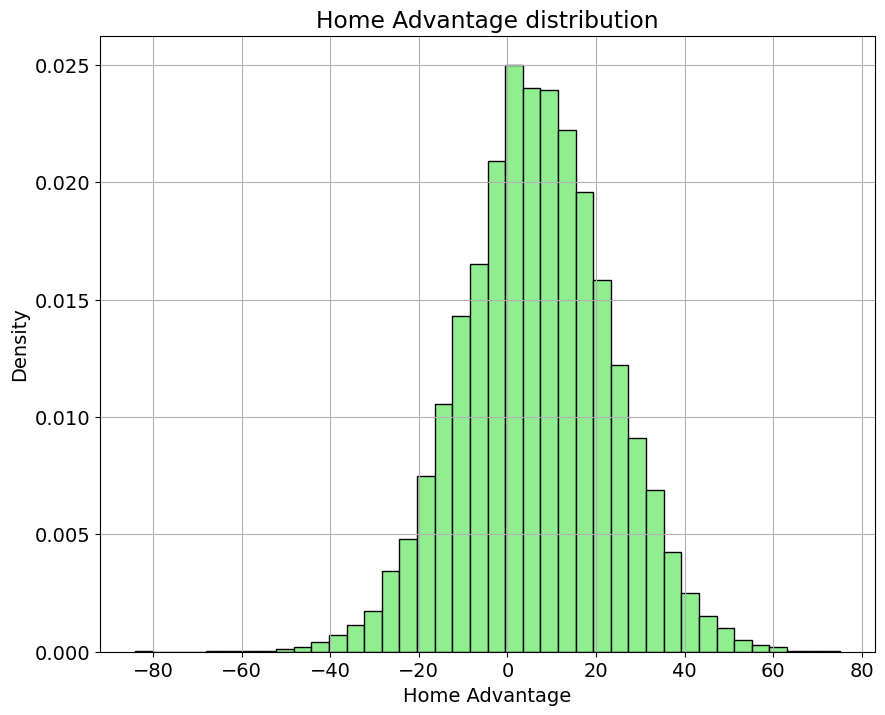

In [281]:
mean_home_advantage = pair_games_df['home_advantage'].mean()
print("home advantage mean:", mean_home_advantage)

plt.figure(figsize=(10, 8))
plt.hist(pair_games_df['home_advantage'], bins=40, density=True, color='lightgreen', edgecolor='black')
plt.title('Home Advantage distribution')
plt.xlabel('Home Advantage')
plt.ylabel('Density')
plt.grid(True)
plt.show()

**(3c).** [2 pts] Let $\mu_{HA}$ be the mean advantage. State your null and alternative hypotheses in math and in words. Please define "home court advantage" in the context of this test instead of using those exact words.

**A:** Math: H_0:  $\mu_{home adv}= 0$ ; H_1: $\mu_{home adv} > 0$

s.t  $\mu_{home adv}$ := mean(home_score_total for both i and j - away_score_total for both i and j)

So the null in words is there is no difference in the mean scores from home scoring and away scoring.
While the one sided alternative is that there is a greater mean for home scoring (for pairs of teams) than for away scoring.

**(3d).** [3 pts] Assuming the game pairs are independent, run a 1-sided t-test to assess whether the mean home advantage is significantly above 0. Print the t-statistic and p-value. Interpret your result.

Hint: You may find `scipy.stats.ttest_1samp` useful.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html

In [282]:
home_advantages = pair_games_df['home_advantage']
t_statistic, p_value = stats.ttest_1samp(home_advantages, 0, alternative='greater')
print("t-statistic:", t_statistic)
print("p-value:", '{:.100f}'.format(p_value))

t-statistic: 58.817665858182025
p-value: 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


**A:** Due to the extemely low p-value calculated, we reject the null. Under the precision of the test, the data being under the null is highly unlikely. This suggests, but is not evidence of, the possibility that teams tend to perform better when playing at home that away.

**(3e).** [2 pts] The one-sample t-test you just ran makes the following 2 assumptions:

1. The mean home advantage is Normally distributed.
2. The home advantages from all the game pairs are independent and identically distributed.

Do these 2 assumptions hold?

*Hint:* This question can be answered by reasoning. No data analysis necessary.

**A:** The first one holds given the amplitude of games played which should see the test stat follow a normal distribution under the CLT. Further, the histogram looks normal by eyeballing.

The second assumption can also be made. There is no indepence within pairs of teams, but there should be between all the pairs. One can consider each new pair under a new light, so that all pairs have no influence between each other. Assuming that loosing streaks have no impact no future game pairs home_advatages, one can assume independence under identical distributions. Multiple games within paired matchups likely leads to learning and conditional strategy. This is not the same for two different matchups, so independence between pairs is assumed.

All pairs should be under similar structures, rules, advantages, and disadvantages, so iid should hold between pairs for home advantage.


As a fun fact, in the National Hockey League, home advantage is actually baked into the rules. During face offs, the home team gets the last change: The home team decides which players to send onto the ice after seeing which players the away team sent. There is no equivalent rule in the NBA, so home advantage in NBA (if it exists) is purely psychological.

## 4. Weekend vs weekday

We will use the NBA dataset to assess whether the total number of points scored is different in weekend vs weekday games. Some people believe more points are scored on the weekend because players are more well-supported by packed audiences on the weekend. On the other hand, some people believe that because players take more time off the weekend, they are more focused and in shape on weekdays, so they might score more points on weekdays.

In this section, we will run a two-sided two-sample t-test. You may assume the two samples $X$ and $Y$ have equal variance. The t-statistic is 

\begin{equation}
    t = \frac{\left(\bar{X} - \bar{Y}\right) - \left(\mu_X - \mu_Y\right)}{s \sqrt{\frac{1}{n_X} + \frac{1}{n_Y}}}
\end{equation}

where $s^2$ is the pooled sample variance:

\begin{equation}
    s^2 = \frac{\left(n_X - 1\right) s_X^2 + \left(n_Y - 1\right) s_Y^2}{\left(n_X - 1\right) + \left(n_Y - 1\right)}
\end{equation}

$n_X$ and $n_Y$ are the numbers of samples, and $s_X^2$ and $s_Y^2$ are the empirical variances.

**(4a).** [1 pt] Create two subsets `df_weekend` and `df_weekday` of games played on weekends/weekdays, respectively. We will continue to restrict to games in 2000-2017 for part 4.

In [283]:
df_weekend = df_millenial_subset[df_millenial_subset['weekend'] == 1]
df_weekday = df_millenial_subset[df_millenial_subset['weekend'] ==0]


**(4b).** [1 pt] What are average total scores for weekend vs weekday games? Print both.

In [285]:
mean_end,  mean_day= df_weekend['Total score'].mean(), df_weekday['Total score'].mean()

print("average weekend total:", mean_end)
print("average weekday total:", mean_day)


average weekend total: 196.4405616224649
average weekday total: 196.9075830797685


**(4c).** [1 pt] What are the standard deviations of the total scores for weekend vs weekday games? Print both.

In [286]:
std_end, std_day = df_weekend['Total score'].std(), df_weekday['Total score'].std()

print("SD weekend total:", std_end)
print("SD weekday total:", std_day)


SD weekend total: 20.758889175257714
SD weekday total: 20.763846986003053


**A:** average weekend total: 196.4405616224649
average weekday total: 196.907583079768.

SD weekend total: 20.758889175257714
SD weekday total: 20.76384698600305

each stat is similar at a glance35

**(4d).** [2 pts] Plot a histogram of the densities of the total scores in games played on weekends and weekdays.

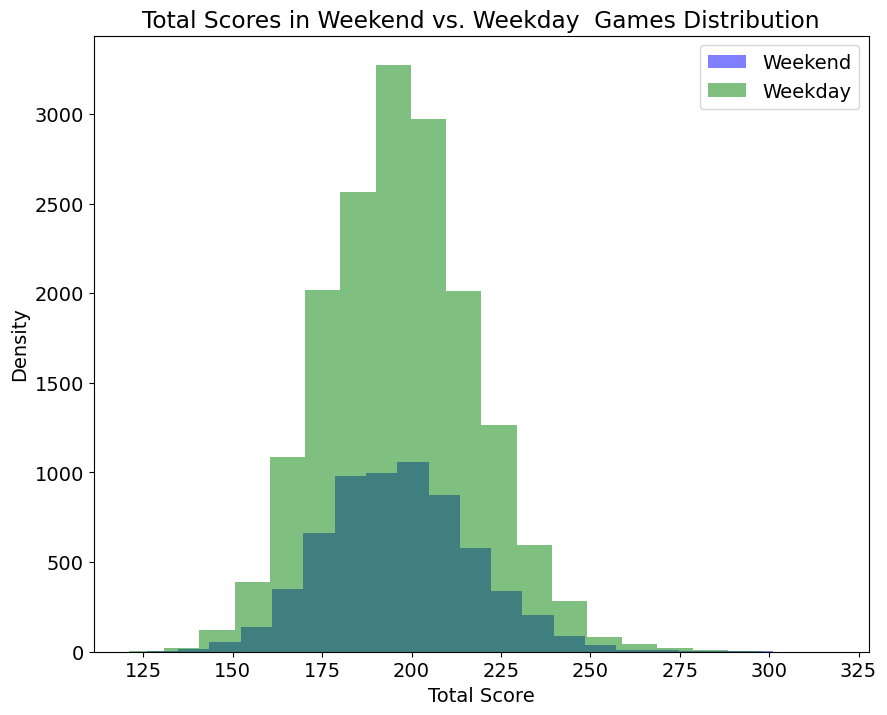

In [287]:
plt.figure(figsize=(10, 8))
plt.hist(df_weekend['Total score'], bins=20, alpha=0.5, color='blue', label='Weekend')
plt.hist(df_weekday['Total score'], bins=20, alpha=0.5, color='green', label='Weekday')
plt.xlabel('Total Score')
plt.ylabel('Density')
plt.title('Total Scores in Weekend vs. Weekday  Games Distribution')
plt.legend()

plt.show()

**(4e).** [2 pts] Let $\mu_0$ and $\mu_1$ be the mean of total scores on the weekdays and weekends, respectively. State your null and alternative hypotheses in math and words.

**A:** Math: H_0:  $\mu= 0$ ; H_1: $\mu \neq 0$


s.t $\mu$ := $X_{mean} - Y_{mean}$

The null is that the difference in means of total scores between weekdays (X) and weekends(Y) is 0, so that there is no difference.

The two-sided alternative is that the difference in means of total scores between weekdays and weekends is not 0.

**(4f).** [3 pts] Assume the total scores from each game are independent and identically distributed. Assume the variances are equal. Run the t-test for your hypotheses. Print the t-statistic and p-value. What would you conclude?

*Hint:* You may use the `ttest_ind` function in `scipy.stats`

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [288]:
t_statistic, p_value = stats.ttest_ind(df_weekday['Total score'], df_weekend['Total score'], equal_var=True)
print("t-stat:", t_statistic)
print("p-value:", p_value)

t-stat: 1.5316667590491844
p-value: 0.12561834234352856


**A:** We fail to reject the null, so that there is not sufficient evidence to deny that total points scored on weekends and weekdays share the same mean center. 

Note: Although we assumed the total scores from each game are independent and identically distributed, this does not necessarily hold. For instance, in the next part, we will see how games with Michael Jordan might tend to have higher scores!

## 5. The Michael Jordan Effect

Widely regarded as the all-time greatest players in the history of the NBA, Michael Jordan led the Chicago Bulls to six championships (1991-93 and 1996-98). The other constants during the 1991-1998 Bulls era were hall of famer Scottie Pipen and coach Phil Jackson. We would like to study whether Jordan's presence on the team was (statistically) significant in bringing the championships to the Bulls.

Conveniently (for us), Jordan retired from basketball after winning three consecutive NBA championships with the Chicago Bulls. He retired ahead of the 1994 season but returned back from retirement late during the 1995 season to eventually lead the Bulls to three more titles in the 1996, 1997, 1998 seasons.

During his absence, both Pipen and Jackson were still at the Bulls, allowing us to study the impact of Michael Jordan's absence on the Chicago Bulls' performance. This fact will allow us to assume that the only change in the years with or without Jordan in the period 1992-1997 was Michael Jordan's presence/absence. You may assume there are no other confounding factors at play.

**(5a).** [2 pts] Produce a subset of the data which includes the following seasons only: 1992-1997. Additionally, the subset should only include games (home or away) featuring the Chicago Bulls.

In [289]:
bulls_df = df[(df['season'] >= 1992) & (df['season'] <= 1997) & ((df['home_team'] == 'Chicago Bulls') | (df['away_team'] == 'Chicago Bulls'))]


**(5b).** [3 pts] Create three new columns on the subset as follows: <br>
1. `for_score`: points scored by the Chicago Bulls (home or away) in the seasons 1992-1997. <br>
2. `against_score`: points scored against the Chicago Bulls (home or away) in the seasons 1992-1997. <br>
3. `net_score`: net score by the Chicago Bulls (home or away) in the seasons 1992-1997.

Your amended dataframe should pass the tests below.

In [290]:
bulls_df['for_score'] = bulls_df['home_pt'].where(df_subset['home_team'] == 'Chicago Bulls', bulls_df['away_pt'])
bulls_df['against_score'] = bulls_df['away_pt'].where(bulls_df['home_team'] == 'Chicago Bulls', bulls_df['home_pt'])
bulls_df['net_score'] = bulls_df['for_score'] - bulls_df['against_score']



In [291]:
test_game = bulls_df.loc[bulls_df['date'] == pd.to_datetime('1997-06-13')]
assert test_game.for_score.values[0] == 90
assert test_game.against_score.values[0] == 86
assert test_game.net_score.values[0] == 4

**(5c).** [1 pt] Using the subset above, produce two disjoint subsets as follows: <br> 
`df_subset_jordan`: includes seasons 1992, 1993, 1996, 1997 (we leave 1994 and 1995 out). <br>
`df_subset_no_jordan`: includes seasons 1994, 1995 only.

In [292]:
df_subset_jordan = bulls_df[bulls_df['season'].isin([1992, 1993, 1996, 1997])]
df_subset_no_jordan = bulls_df[bulls_df['season'].isin([1994, 1995])]


**(5d).** [2 pts] Let $\mu_1$ be the means of `for_score` for the Chicago bulls during the Jordan seasons ('92, '93, '96, '97). Let $\mu_0$ be the means of `for_score` for the Chicago bulls during the seasons without him ('94, '95). What are the null and alternate hypotheses if we want to assess the Michael Jordan effect on `for_score` in these two time periods? Please state in math and in words.

**A:** Math: H_0:  $\mu= 0$ ; H_1: $\mu \neq 0$


s.t $\mu$ := $\mu_{1}- \mu_{0}$

Null: The mean score of points for the bulls with Michael(('92, '93, '96, '97) is equivalent to that without him('94, '95).

Alt: The mean score of points for the bulls with Micheal is not equivalent to that without him.

**(5e).** [1 pt] Produce the mean `for_score` by the Chicago Bulls during the Jordan seasons and the seasons without him. Print both.

In [293]:
mean_score_jordan, mean_score_no_jordan= df_subset_jordan['for_score'].mean(), df_subset_no_jordan['for_score'].mean()
print('mean points by the bulls with jordan', mean_score_jordan)
print('mean points by the bulls without jordan', mean_score_no_jordan)

mean points by the bulls with jordan 104.39162561576354
mean points by the bulls without jordan 99.33695652173913


**(5f).** [2 pts] Conduct a two-sample t-test for differences between the `for_score` during the Michael Jordan seasons and seasons without him. Feel free to use the `scipy.stats` library to perform the t-test for independent samples and assume equal variances. Print the t-statistic and the associated p-value.

In [297]:
t_stat, p_value =stats.ttest_ind(df_subset_jordan['for_score'], df_subset_no_jordan['for_score'], equal_var=True)
print("t-stat:", t_stat)
print("p-val:", p_value)

t-stat: 4.756150092729335
p-val: 2.4852089514923217e-06


**(5g).** [3 pts] Repeat 5e and 5f for the `against_score`. Print the t-statistic and the associated p-value.

In [299]:
mean_against_score_jordan, mean_against_score_no_jordan = df_subset_jordan['against_score'].mean(), df_subset_no_jordan['against_score'].mean()

print('mean points against the bulls with Jordan', mean_against_score_jordan)
print('mean points against the bulls without Jordan', mean_against_score_no_jordan)
t_stat, p_value= stats.ttest_ind(df_subset_jordan['against_score'], df_subset_no_jordan['against_score'],  equal_var=True)
print("t-stat:",t_stat)
print("p-val:", p_value)


mean points against the bulls with Jordan 95.02216748768473
mean points against the bulls without Jordan 95.60326086956522
t-stat: -0.5878270595434669
p-val: 0.5568740583479378


**(5h).** [2 pts] What would you conclude based on the two tests?

**A:** For the for_score, there seems to be a significant difference in mean for when the Bulls had Micheal. This is to say that we should reject the null with such small p-value. So this implies the team with Michael created more points for the bulls. For the against_score, we find that there is no significant points scored against the bulls without Michael, so we would fail to reject a null that claims that the bulls got scored on equivalently with and without Michael.

**(5i).** [3 pts] Repeat 5e and 5f for the `net_score`. Print the t-statistic and the associated p-value.

In [300]:
mean_net_score_jordan, mean_net_score_no_jordan= df_subset_jordan['net_score'].mean(), df_subset_no_jordan['net_score'].mean()

print('mean bulls net score with Jordan:', mean_net_score_jordan)
print('mean bulls net score without Jordan:', mean_net_score_no_jordan)
t_stat, p_value= stats.ttest_ind(df_subset_jordan['net_score'], df_subset_no_jordan['net_score'], equal_var=True)
print("t-stat:", t_stat)
print("p-val:", p_value)


mean bulls net score with Jordan: 9.369458128078819
mean bulls net score without Jordan: 3.733695652173913
t-stat: 5.032968529925134
p-val: 6.428319460107873e-07


**(5j).** [1 pt] Does this test confirm the conclusion you reached based on the earlier two tests?

**A:** Yes, it corresponds to a Michael Absence implying less scoring by the bulls. While we can't reject that the bulls 
got scored on in like fashion with and without Michael, this net_score test confirms that Michael significantly imposed a decrease in net mean score for the bulls, and from the bulls ability to score more with him than without him.

**(5k).** [2 pts] While Scottie Pipen and Phil Jackson were constants during the entire period 1992-1998, can you think of reasons to cast doubt on the conclusions reached by the tests?

*Hint:* We want you to question whether the assumption about "no other confounding variables" is valid? Could there be other factors at play?

**A:** It was known that Michael was not going to play in those periods. So perhaps the confounding was more so psycological for both the Bulls and the Fans. Without the engagement of Michael, there could be more or less fan engagement/scrutiny that affects mindsets of the players in the Bulls. So while there is significant reaason to say that the Bulls did not perform as well as without Michael, we can't directly conclude that it was Michael's prowess alone that gave the bulls more points. Perhaps it was a shift in team/fanbase mindsets for the Bulls that affected offensive game play

## 6. Do back-to-back games impact scoring? (OPTIONAL: NOT FOR GRADE)
We want to test whether teams playing back-to-back games (i.e. playing on consecutive nights of the week) has any effect on total scoring during a game. 

**(6a).** Write a function, `rest_days()` which takes as input the complete dataset as a dataframe and adds a new column which records the total number of nights of rest that the home and away teams have had for each game. Call your function to update the dataframe.

*Note:* the column must track the <b>sum</b> of the rest days for the home and away team.

If a team has a prolonged rest (i.e. > 7 days), set that to 8 days. This will help eliminate the skewed effects of strikes and long periods off (e.g. the summer). The first game for a team can be set to 8 days as well. Therefore, the range for the new column is 2-16 days (both inclusive).

Your function should pass the test case below.

In [ ]:
def rest_days(df):
    '''
    Add a column for the total number of rest days the home and away team have before a game
    @param df: pandas DataFrame, contains columns date, home_team, away_team, etc., will be modified by function
    @return: None
    '''
    pass

In [ ]:
rest_days(df)
assert df.loc[np.logical_and.reduce((df['home_team'] == 'Boston Celtics',
                                     df['away_team'] == 'Miami Heat',
                                     df['date'] == pd.to_datetime('2017-03-26')))].rest.values[0] == 5

**(6b).** Produce a histogram of the rest days with 10 bins

**(6c).** What does the histogram tell you about the schedule of an NBA team during the season?

**A:** (Type your answer here)

**(6d).** For the seasons 2000-2017 only, produce two subsets:<br>
`back_to_back`: with games where the rest days are <= 3 (i.e. at least one team is playing back-to-back)<br>
`longer`: games where the rest days are >=4 and <= 5.

**(6e).** What would your Null Hypothesis be if you wanted to test whether back_to_back games produce different total scores than games with combined rest between 4-5 days? Assume there are no other confounding variables at play.

**A:** (Type your answer here)

**(6f).** Print the mean total scores per game for the <b>back_to_back</b> and <b>longer</b> subsets (for seasons 2000-2017).

**(6g).** For the seasons 2000-2017 and using the two subsets you created, conduct a two-sample t-test to test your hypothesis. Feel free to use the `scipy.stats` library to perform the t-test for independent samples with equal variances. Print the t-statistic and the associated p-value.

**(6h).** What do you conclude about back-to-back games?

**A:** (Type your answer here)

**(6i).** Do you think the difference/no difference between <= 3 rest days and 4-5 rest days could be a result of confounding (i.e. other factors which may explain or be responsible for the observations)? What could be the confounding factors?

*Hint:* Think about situations during the season when the distributions of rest days could be different. 

**A:** (Type your answer here)